In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit

from theano import tensor as tt

from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std() 

## Ex. 1

“dislike” nominations by 18 monks living in the same monastery over three time
periods. Therefore the observed variables are counts from 0 to 3 of times monk A
nominated monk B as liked or disliked.1 Each row in the data is a pair of monks (a
dyad). The variables are:

- A: Index number for first monk in dyad
- B: Index number for second monk in dyad
- like_AB: Number of times A nominated B as liked
- like_BA: Number of times B nominated A as liked
- dislike_AB: Number of times A nominated B as disliked
- dislike_BA: Number of times B nominated A as disliked

Use these data to estimate the amount of reciprocity in “like” nominations within
dyads. You can ignore the “dislike” data for now. Use the social network example
from the book to help, but you should modify it appropriately.

In [19]:
df = pd.read_csv('data/Monks.csv', sep=',')
print(df.shape)
df.head()

(153, 9)


,dyad_id,A,B,like_AB,like_BA,dislike_AB,dislike_BA,A_name,B_name
0,1,1,2,0,3,0,0,ROMUL,BONAVEN
1,2,1,3,3,3,0,0,ROMUL,AMBROSE
2,3,1,4,0,0,0,0,ROMUL,BERTH
3,4,1,5,0,0,0,0,ROMUL,PETER
4,5,1,6,0,0,0,0,ROMUL,LOUIS


Model definition: \
We are interested in finding out the liking reciprocity.
We model alpha as an average tendency to give a like to another person and then a D parameter to estimate the difference from average in a specific dyad for a AB direction.
In the second linear model, we estimate the difference from average in a specific dyad for the BA direction.

The priors for the D parameters come from multivariate normal distribution and we are interested in estimating the parameters of this distribution, in particular the correlation coefficient, which will give us information about the reciprocity of the liking behaviour.

\begin{split}
y_{\text{AB}}  &\sim Poisson(\lambda_{\text{AB}}) \\
log(\lambda_{\text{AB}}) &= \alpha + D_{\text{AB}} \\
\end{split}


\begin{split}
y_{\text{BA}}  &\sim Poisson(\lambda_{\text{BA}}) \\
log(\lambda_{\text{BA}}) &= \alpha + D_{\text{BA}} \\
\end{split}

\begin{split}
\alpha  &\sim Normal(0, 1) \\
\end{split}

\begin{pmatrix}D_{\text{AB}} \\ D_{\text{BA}} \end{pmatrix} \sim MVNormal \left( \begin{bmatrix}0 \\ 0 \end{bmatrix} , \textbf{S} \right)  

S is a covariance matrix, which indicates how the two effects (A liking B and B liking A) relate to each other.

\begin{split}
\textbf{S} = \begin{pmatrix} \sigma_{DAB} & 0 \\ 0 & \sigma_{DBA} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{DAB} & 0 \\ 0 & \sigma_{DBA} \end{pmatrix}
\end{split}

Finally, our interest is to estimate Rho, the correlation coefficient between the two effects. If it is positive, it meas that there is reciprocity between the likes.

In [20]:
D_id = df.dyad_id-1 #to have dyades starting with 0 for indexing
like_AB = df.like_AB
like_BA = df.like_BA

dislike_AB = df.dislike_AB
dislike_BA = df.dislike_BA

N = df.B.max()

A = df.A-1
B = df.B-1

In [21]:
len(D_id)

153

In [22]:

with pm.Model() as m_8_1:
    #prior stddev in slopes (variation accross dyades)
    sd_dist = pm.Exponential.dist(1)

    # get back standard deviations and rho:
    chol_d, corr, stds = pm.LKJCholeskyCov("chol_d", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)

    # population of varying effects
    d = pm.MvNormal("d", mu=0.0, chol=chol_d, shape=(len(D_id), 2))

    #prior for average intercept (average liking rate accross dyads)
    a = pm.Normal("a", mu=0, sd=1)

    # linear model (modelling the lambda parameter of the outcome as binomial with 3 trials (max. 3 likes) 
    pAB = pm.math.invlogit(a + d[D_id, 0])
    pBA = pm.math.invlogit(a + d[D_id, 1])

    likesAB = pm.Binomial("likesAB", 3, pAB, observed=like_AB)
    likesBA = pm.Binomial("likesBA", 3, pBA, observed=like_BA)

    trace_8_1 = pm.sample(2000, tune=3000)

    idata_8_1 = az.from_pymc3(
        trace_8_1,
        dims={"d": ["Dyad", "Monk"]},
    )

    post = idata_8_1.posterior = idata_8_1.posterior.rename_vars(
        {
            "chol_d_corr": "Rho_d",
            "chol_d_stds": "sigma_d"
        }
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, d, chol_d]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 114 seconds.
The number of effective samples is smaller than 10% for some parameters.


The sampling did not do optimally, so let´s reparametrize the model:

In [23]:

with pm.Model() as m_8_1_nc:
    #prior stddev in slopes (variation accross dyades)
    sd_dist = pm.Exponential.dist(1)

    # get back standard deviations and rho:
    chol_d, corr, stds = pm.LKJCholeskyCov("chol_d", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)

    # population of varying effects
    z = pm.Normal("z", 0, 1, shape=(2, len(D_id)))
    d = pm.Deterministic("d", pm.math.dot(chol_d, z).T)

    #prior for average intercept (average liking rate accross dyads)
    a = pm.Normal("a", mu=0, sd=1)

    # linear model (modelling the lambda parameter of hte outcome with a poisson distribution)
    pAB = pm.math.invlogit(a + d[D_id, 0])
    pBA = pm.math.invlogit(a + d[D_id, 1])

    likesAB = pm.Binomial("likesAB", 3, pAB, observed=like_AB)
    likesBA = pm.Binomial("likesBA", 3, pBA, observed=like_BA)

    trace_8_1_nc = pm.sample(
        5000, 
        tune=5000,
        target_accept=0.99)

    idata_8_1_nc = az.from_pymc3(
        trace_8_1_nc,
        dims={"d": ["Dyad", "Monk"]},
    )

    post_nc = idata_8_1_nc.posterior = idata_8_1_nc.posterior.rename_vars(
        {
            "chol_d_corr": "Rho_d",
            "chol_d_stds": "sigma_d"
        }
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, z, chol_d]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 190 seconds.


In [24]:
with m_8_1_nc:
    sum_nc = az.summary(idata_8_1_nc, round_to=2,var_names=['a','Rho_d','sigma_d'])
sum_nc


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-4.05,0.40,-4.80,-3.31,0.00,0.0,9919.10,12246.64,1.0
"Rho_d[0, 0]",1.00,0.00,1.00,1.00,0.00,0.0,20000.00,20000.00,NaN
"Rho_d[0, 1]",0.67,0.11,0.46,0.86,0.00,0.0,5228.66,9047.10,1.0
"Rho_d[1, 0]",0.67,0.11,0.46,0.86,0.00,0.0,5228.66,9047.10,1.0
"Rho_d[1, 1]",1.00,0.00,1.00,1.00,0.00,0.0,18874.14,18827.84,1.0
sigma_d[0],2.69,0.40,1.97,3.46,0.00,0.0,7309.99,11741.12,1.0
sigma_d[1],3.84,0.53,2.86,4.82,0.01,0.0,7565.33,11573.36,1.0


In [26]:
#extracting rho[1,0| using trace data
trace_8_1_nc['chol_d_corr'][:,1][:,0]

#extracting rho[1,0| using inference data object
idata_8_1_nc.posterior.Rho_d.sel(chol_d_corr_dim_0=1, chol_d_corr_dim_1=0).data.flatten()

array([0.79396755, 0.81461267, 0.61900414, ..., 0.72959629, 0.72056934,
       0.59386115])

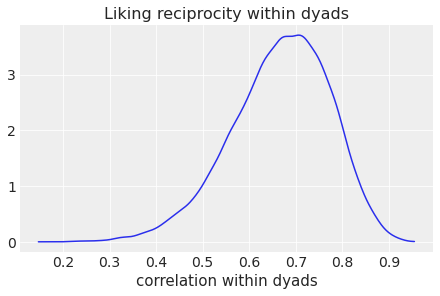

In [27]:
#plotting using inference data object
fig, ax = plt.subplots()

az.plot_kde(post_nc.Rho_d.sel(chol_d_corr_dim_0=1, chol_d_corr_dim_1=0).data.flatten(), ax=ax)

ax.set(xlabel='correlation within dyads', title='Liking reciprocity within dyads');


## Ex. 2
Now also analyze the “dislike” nominations. Estimate the amount of reciprocity
in the “dislike” nominations and compare to the estimate from the “like” nominations.
Does “like” or “dislike” have higher reciprocity? Be sure to compute the
posterior contrast between the two estimates. \

Solution: we will add parameters for disliking to the second model analogically to the liking parameters in the first model

In [28]:

with pm.Model() as m_8_2_nc:
    #prior stddev in slopes (variation accross dyades)
    sd_dist_likes = pm.Exponential.dist(1)
    sd_dist_dislikes = pm.Exponential.dist(1)

    # get back standard deviations and
    chol_d_l, corr, stds = pm.LKJCholeskyCov("chol_d_l", n=2, eta=2.0, sd_dist=sd_dist_likes, compute_corr=True)
    chol_d_d, corr, stds = pm.LKJCholeskyCov("chol_d_d", n=2, eta=2.0, sd_dist=sd_dist_dislikes, compute_corr=True)

    # population of varying effects for likes
    z_l = pm.Normal("z_l", 0, 1, shape=(2, len(D_id)))
    d_l = pm.Deterministic("d_l", pm.math.dot(chol_d_l, z_l).T)

    # population of varying effects for dislikes
    z_d = pm.Normal("z_d", 0, 1, shape=(2, len(D_id)))
    d_d = pm.Deterministic("d_d", pm.math.dot(chol_d_d, z_d).T)

    #prior for average intercept (average liking rate accross dyads)
    a_l = pm.Normal("a_l", mu=0, sd=1)
    a_d = pm.Normal("a_d", mu=0, sd=1)

    # linear model likes
    pAB_likes = pm.math.invlogit(a_l + d_l[D_id, 0])
    pBA_likes = pm.math.invlogit(a_l + d_l[D_id, 1])

    # linear model dislikes
    pAB_dislikes = pm.math.invlogit(a_d + d_d[D_id, 0])
    pBA_dislikes = pm.math.invlogit(a_d + d_d[D_id, 1])

    likesAB = pm.Binomial("likesAB", 3, pAB_likes, observed=like_AB)
    likesBA = pm.Binomial("likesBA", 3, pBA_likes, observed=like_BA)

    dislikesAB = pm.Binomial("dislikesAB", 3, pAB_dislikes, observed=dislike_AB)
    dislikesBA = pm.Binomial("sidlikesBA", 3, pBA_dislikes, observed=dislike_BA)

    trace_8_2_nc = pm.sample(
        5000, 
        tune=5000,
        target_accept=0.99)

    idata_8_2_nc = az.from_pymc3(
        trace_8_2_nc,
        dims={"d": ["Dyad", "Monk"]},
    )

    post_nc = idata_8_2_nc.posterior = idata_8_2_nc.posterior.rename_vars(
        {
            "chol_d_l_corr": "Rho_d_likes",
            "chol_d_l_stds": "sigma_d_likes",
            "chol_d_d_corr": "Rho_d_dislikes",
            "chol_d_d_stds": "sigma_d_dislikes"
        }
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_d, a_l, z_d, z_l, chol_d_d, chol_d_l]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 329 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
with m_8_2_nc:
    sum_nc = az.summary(idata_8_2_nc, round_to=2,var_names=['a_l','a_d','Rho_d_likes','sigma_d_likes', 'Rho_d_dislikes','sigma_d_dislikes'])
sum_nc

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_l,-4.07,0.40,-4.83,-3.34,0.00,0.0,8296.15,11496.76,1.0
a_d,-4.39,0.42,-5.18,-3.62,0.00,0.0,8276.22,11263.12,1.0
"Rho_d_likes[0, 0]",1.00,0.00,1.00,1.00,0.00,0.0,20000.00,20000.00,NaN
"Rho_d_likes[0, 1]",0.66,0.11,0.46,0.85,0.00,0.0,3773.71,6548.27,1.0
"Rho_d_likes[1, 0]",0.66,0.11,0.46,0.85,0.00,0.0,3773.71,6548.27,1.0
"Rho_d_likes[1, 1]",1.00,0.00,1.00,1.00,0.00,0.0,19654.61,19474.42,1.0
sigma_d_likes[0],2.70,0.40,1.98,3.46,0.00,0.0,6692.30,10936.69,1.0
sigma_d_likes[1],3.86,0.53,2.87,4.84,0.01,0.0,6344.09,10600.49,1.0
"Rho_d_dislikes[0, 0]",1.00,0.00,1.00,1.00,0.00,0.0,20000.00,20000.00,NaN
"Rho_d_dislikes[0, 1]",0.45,0.14,0.19,0.69,0.00,0.0,4355.76,8996.10,1.0


Computing contrast:

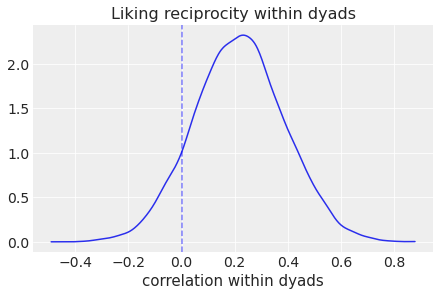

In [30]:
r_likes = idata_8_2_nc.posterior.Rho_d_likes.sel(chol_d_l_corr_dim_0=1, chol_d_l_corr_dim_1=0).data.flatten()
r_dislikes = idata_8_2_nc.posterior.Rho_d_dislikes.sel(chol_d_d_corr_dim_0=1, chol_d_d_corr_dim_1=0).data.flatten()

contrast = r_likes - r_dislikes

fig, ax = plt.subplots()

az.plot_kde(contrast, ax=ax)

ax.axvline(x=0, linestyle='dashed', color='b', alpha=0.5)

ax.set(xlabel='correlation within dyads', title='Liking reciprocity within dyads');



In [31]:
np.quantile(contrast, [0, 0.25, 0.5, 0.75, 1])

array([-0.49198644,  0.09974012,  0.21557374,  0.32923888,  0.87945853])

Conclusion: we see that there is more reciprocity (more than 75% of the mass is positive) in liking then in disliking.

# Ex. 3

Now consider generalized liking and disliking. Add generalized “receiving” parameters
to the model, analogous to receiving varying effects from the sharing example
in the book/lecture. (Each monk only named 3 likes and 3 dislikes each time,
so the amount of “giving” is fixed by design in these data.) Can you identify any
individuals who are particularly liked/disliked, independent of the dyadic relations?

In [5]:
D_id = df.dyad_id-1 #to have dyades starting with 0 for indexing
like_AB = df.like_AB
like_BA = df.like_BA

dislike_AB = df.dislike_AB
dislike_BA = df.dislike_BA

N = df.B.max()

A = df.A-1
B = df.B-1

In [10]:

with pm.Model() as m_8_3_nc:
    ## effect of receiving accross single persons for likes and dislikes (non-centered)
    sd_dist = pm.Exponential.dist(1.0)

    chol_rec, corr, stds = pm.LKJCholeskyCov("chol_rec", n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    z_gr = pm.Normal("z_gr", 0, 1, shape=(2, N))
    gr = pm.Deterministic("gr", pm.math.dot(chol_rec, z_gr).T)

    #----- likes and dislikes accross dyads-----
    #prior stddev in slopes (variation accross dyades)
    sd_dist_likes = pm.Exponential.dist(1)
    sd_dist_dislikes = pm.Exponential.dist(1)

    # get back standard deviations and rho
    chol_d_l, corr, stds = pm.LKJCholeskyCov("chol_d_l", n=2, eta=2.0, sd_dist=sd_dist_likes, compute_corr=True)
    chol_d_d, corr, stds = pm.LKJCholeskyCov("chol_d_d", n=2, eta=2.0, sd_dist=sd_dist_dislikes, compute_corr=True)

    # population of varying effects for likes
    z_l = pm.Normal("z_l", 0, 1, shape=(2, len(D_id)))
    d_l = pm.Deterministic("d_l", pm.math.dot(chol_d_l, z_l).T)

    # population of varying effects for dislikes
    z_d = pm.Normal("z_d", 0, 1, shape=(2, len(D_id)))
    d_d = pm.Deterministic("d_d", pm.math.dot(chol_d_d, z_d).T)

    #prior for average intercept (average liking and disliking rate accross dyads)
    a_l = pm.Normal("a_l", mu=0, sd=1)
    a_d = pm.Normal("a_d", mu=0, sd=1)

    # linear model likes
    pAB_likes = pm.math.invlogit(a_l + d_l[D_id, 0] + gr[B, 0])
    pBA_likes = pm.math.invlogit(a_l + d_l[D_id, 1] + gr[A, 0])

    # linear model dislikes
    pAB_dislikes = pm.math.invlogit(a_d + d_d[D_id, 0] + gr[B, 1])
    pBA_dislikes = pm.math.invlogit(a_d + d_d[D_id, 1] + gr[B, 1])

    likesAB = pm.Binomial("likesAB", 3, pAB_likes, observed=like_AB)
    likesBA = pm.Binomial("likesBA", 3, pBA_likes, observed=like_BA)

    dislikesAB = pm.Binomial("dislikesAB", 3, pAB_dislikes, observed=dislike_AB)
    dislikesBA = pm.Binomial("sidlikesBA", 3, pBA_dislikes, observed=dislike_BA)

    trace_8_3_nc = pm.sample(
        5000, 
        tune=5000,
        target_accept=0.99)

    idata_8_3_nc = az.from_pymc3(
        trace_8_3_nc,
        dims={"d": ["Dyad", "Monk"], "gr": ['Monk_','Rate']},
        coords={'Rate': ['receiving_likes','receiving_dislikes']}
    )
    post_nc = idata_8_3_nc.posterior = idata_8_3_nc.posterior.rename_vars(
        {
            "chol_d_l_corr": "Rho_d_likes",
            "chol_d_l_stds": "sigma_d_likes",
            "chol_d_d_corr": "Rho_d_dislikes",
            "chol_d_d_stds": "sigma_d_dislikes",
            "chol_rec_corr": "Rho_receiving",
            "chol_rec_stds": "sigma_receiving"
        }
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_d, a_l, z_d, z_l, chol_d_d, chol_d_l, z_gr, chol_rec]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 814 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
with m_8_3_nc:
    sum_8_3_nc = az.summary(idata_8_3_nc, round_to=2,var_names=['a_l','a_d', 'gr', 'Rho_d_likes','sigma_d_likes', 'Rho_d_dislikes','sigma_d_dislikes', 'Rho_receiving','sigma_receiving'])
sum_8_3_nc



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_l,-4.04,0.42,-4.87,-3.28,0.00,0.00,13166.85,15520.65,1.0
a_d,-3.94,0.70,-5.23,-2.60,0.01,0.01,7664.97,8859.58,1.0
"gr[0, receiving_likes]",0.11,0.49,-0.79,1.18,0.00,0.00,24167.19,15412.94,1.0
"gr[0, receiving_dislikes]",-0.04,2.13,-4.25,3.91,0.01,0.02,37989.46,13537.04,1.0
"gr[1, receiving_likes]",0.20,0.50,-0.61,1.33,0.00,0.00,14254.99,13694.76,1.0
"gr[1, receiving_dislikes]",-0.82,2.02,-4.75,2.77,0.02,0.01,18332.24,12952.52,1.0
"gr[2, receiving_likes]",-0.11,0.49,-1.13,0.82,0.00,0.00,21242.49,14537.10,1.0
"gr[2, receiving_dislikes]",-1.20,2.01,-5.03,2.13,0.02,0.01,12045.14,11198.96,1.0
"gr[3, receiving_likes]",0.11,0.49,-0.79,1.17,0.00,0.00,19737.36,15230.87,1.0
"gr[3, receiving_dislikes]",-1.54,2.04,-5.53,1.64,0.02,0.02,10006.14,10826.04,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

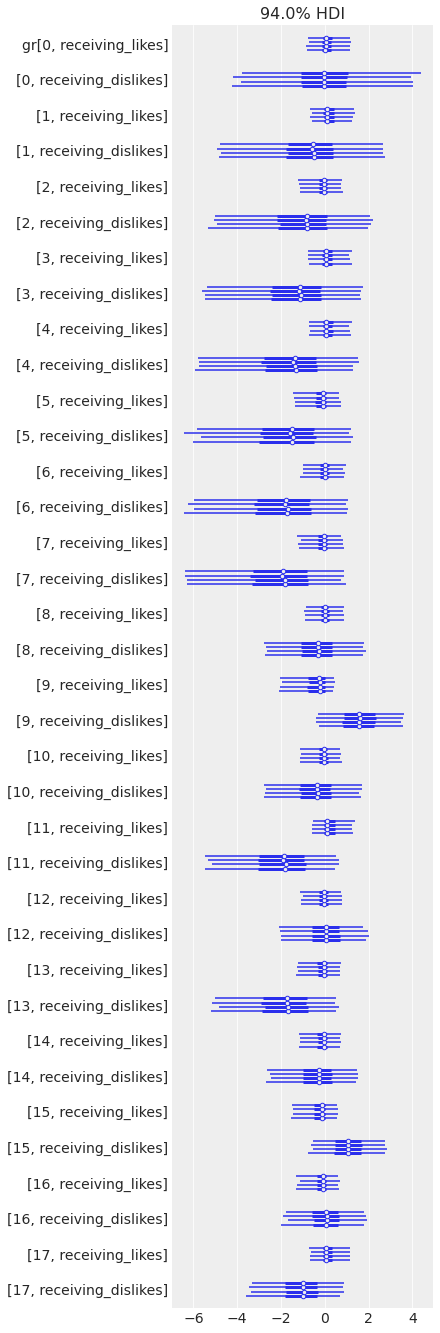

In [14]:
az.plot_forest(idata_8_3_nc,var_names=['gr'])

Conclusions:
- Monks with index 9 and 15 (i.e. numbers 10 and 16 in the dataset) received more than average amount of dislikes.